In [1]:
from dataset import download_dataset, generate_taxonomy_dataframe, BeetleSet, TransformsDataset, stratified_split, generate_labels_dict, stratified_split_equal
from models import SimpleMultiTaskModel, SequentialMultiTaskModel, SkipMultiTaskModel
from train import fit, test, get_accuracy, get_all_metrics, get_dists

import torch
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
import torchvision
import numpy as np
import pandas as pd

import json
from pathlib import Path

from analysis.hierarchy_graph import Graph
import os

import models

In [2]:
import analysis.utility as util

In [3]:
import analysis.cluster as cluster

# Global parameters

In [4]:
models_info = util.load_models_info(util.root)
util.show_models(models_info)

,Group,Model name,Model type,Parent index,Index,Taxa order
0,baseline,parallel2_0123,SimpleMultiTaskModel,0,0,"[subfamily, tribe, genus, species]"
1,baseline,parallel_0123,SimpleMultiTaskModel,0,1,"[subfamily, tribe, genus, species]"
2,baseline,parallel_resnet34_0123,SimpleMultiTaskModel,0,2,"[subfamily, tribe, genus, species]"
3,baseline,sequential2_0123,SequentialMultiTaskModel,0,3,"[subfamily, tribe, genus, species]"
4,baseline,sequential2_3210,SequentialMultiTaskModel,0,4,"[species, genus, tribe, subfamily]"
5,baseline,sequential_0123,SequentialMultiTaskModel,0,5,"[subfamily, tribe, genus, species]"
6,baseline,sequential_3210,SequentialMultiTaskModel,0,6,"[species, genus, tribe, subfamily]"
7,baseline,sequential_resnet34_3210,SequentialMultiTaskModel,0,7,"[species, genus, tribe, subfamily]"
8,baseline,single2_0,SequentialMultiTaskModel,0,8,[subfamily]
9,baseline,single2_0123,SequentialMultiTaskModel,0,9,"[subfamily, tribe, genus, species]"


In [5]:
model_data = util.calc_dataframe(models_info, 0, 0)

0


/home/thorreign/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


AttributeError: 'Series' object has no attribute 'lower'

In [ ]:
data = util.df_correct(util.df_pred(model_data['test_set']))

In [ ]:
np.sum(data.species.to_numpy())/data.species.to_numpy().shape[0]

0.9125090383224873

In [ ]:
def find_hard_cases(path, taxa):
    folder = os.listdir(path)
    dataframes = []
    for i in range(len(folder)):
        temp = util.df_correct(util.df_pred(util.read_dataframe_(path + folder[i] + '/test.csv')))
        dataframes.append(temp)
    return util.get_same(dataframes, taxa)


In [ ]:
same_cases = find_hard_cases('./dataframes/', 'species')

In [ ]:
same_cases

,id,species,path
0,62,False,data/beetles/images/bisnius_cephalotes/_0344_4...
1,81,False,data/beetles/images/bisnius_fimetarius/_0335_4...
2,197,False,data/beetles/images/gabrius_appendiculatus/_04...
3,211,False,data/beetles/images/gabrius_keysianus/_0435_30...
4,359,False,data/beetles/images/lathrobium_geminum/_0142_5...
5,433,False,data/beetles/images/lithocharis_nigriceps/_010...
6,770,False,data/beetles/images/philonthus_fumarius/_0401_...
7,781,False,data/beetles/images/philonthus_intermedius/_02...
8,958,False,data/beetles/images/philonthus_umbratilis/_034...
9,962,False,data/beetles/images/philonthus_umbratilis/_034...


In [ ]:
same_cases.iloc[[1]]['path'].to_list()[0]

'data/beetles/images/bisnius_fimetarius/_0335_43.jpg'

In [ ]:
from PIL import Image


In [ ]:
same_cases.iloc[[nr]]['path'].to_list()[0]

'data/beetles/images/philonthus_umbratilis/_0340_37.jpg'

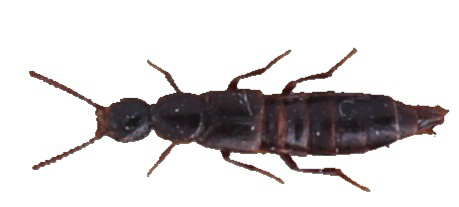

In [ ]:
nr = 9
false_img = Image.open(same_cases.iloc[[nr]]['path'].to_list()[0])
false_img

In [ ]:
def incorrect_freq(model, taxa='species'):
    test_data = model['test_set']
    feats = np.array(test_data[taxa+ '_logits'].to_list())
    labels = test_data[taxa+ '_label'].to_numpy()
    preds = np.argmax(feats, axis=1)
    correct = labels[labels==preds]
    distr = np.bincount(labels)
    corr_distr = np.bincount(correct, minlength=np.unique(preds).shape[0])
    freq = corr_distr/distr
    n_distr = distr - np.min(distr)
    n_distr = n_distr / np.max(n_distr)
    return util.compare_fit(freq, n_distr)


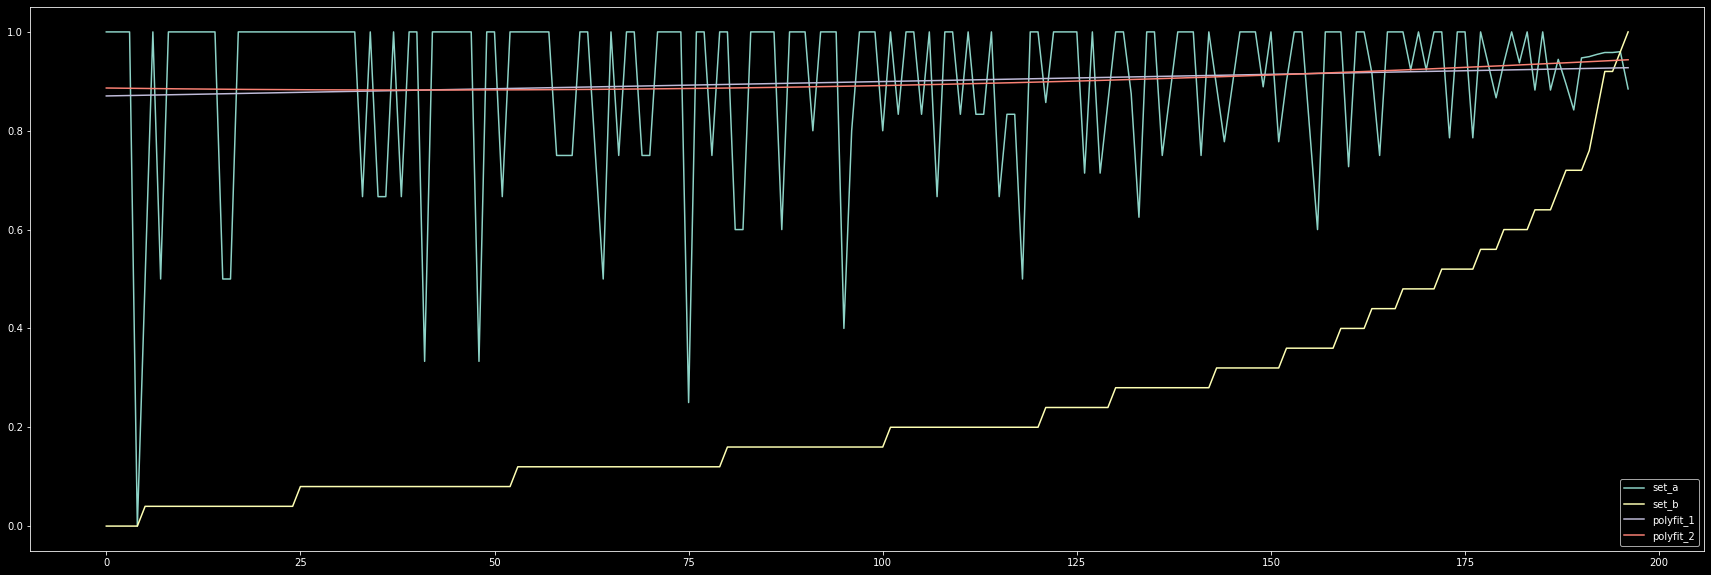

In [ ]:
_ = incorrect_freq(model_data)

In [ ]:
block

NameError: name 'block' is not defined

In [ ]:
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:

clist = np.array(list(mcolors.CSS4_COLORS.keys()))


In [ ]:
pca_2d = PCA(n_components=2)

In [ ]:
dataframe = model_data['train_set']
dataframe_test = model_data['test_set']

In [ ]:
features_test = np.array(dataframe['species_logits'].to_list())

In [ ]:
testset = np.array(dataframe_test['species_logits'].to_list())

In [ ]:
pca_test = pca_2d.fit_transform(features_test)

In [ ]:
pca_test_c_l = get_clusters(pca_test, dataframe['species_label'].to_numpy())

In [ ]:
pca_set = pca_2d.transform(testset)

In [ ]:
f_label = dataframe['species_label'].to_numpy()

In [ ]:
f_label%len(clist)

array([ 0,  0,  0, ..., 48, 48, 48])

In [ ]:
test1 = np.arange(10)
test2 = np.array([3,4])
np.where(test1 == test2[1])[0]

array([4])

In [ ]:
tra = model_data['train_set']

In [ ]:
tra.loc[tra['species_label'].isin([1])]

,id,subfamily_logits,subfamily_label,tribe_logits,tribe_label,genus_logits,genus_label,species_logits,species_label,path
20,20,"[-18.61235237121582, 19.13530731201172]",1,"[-42.68336486816406, -17.286182403564453, 15.3...",2,"[-30.077625274658203, 19.427005767822266, -19....",1,"[-46.099735260009766, 12.31965446472168, -9.14...",1,data/beetles/images/acylophorus_glaberrimus/_0...
21,21,"[-16.12808609008789, 16.696537017822266]",1,"[-44.30292892456055, -22.240266799926758, 17.8...",2,"[-29.71596908569336, 16.053422927856445, -19.3...",1,"[-47.66305160522461, 12.276540756225586, -3.45...",1,data/beetles/images/acylophorus_glaberrimus/_0...
22,22,"[-26.78883934020996, 27.361743927001953]",1,"[-46.540653228759766, -27.879968643188477, 20....",2,"[-29.409624099731445, 14.329561233520508, -20....",1,"[-44.31939697265625, 10.605149269104004, -4.38...",1,data/beetles/images/acylophorus_glaberrimus/_0...
23,23,"[-5.682024002075195, 6.1199164390563965]",1,"[-36.513336181640625, -7.037818431854248, 10.4...",2,"[-28.66998863220215, 14.335954666137695, -18.5...",1,"[-32.22176742553711, 7.164671421051025, -3.478...",1,data/beetles/images/acylophorus_glaberrimus/_0...
24,24,"[-23.42852783203125, 23.985517501831055]",1,"[-45.22818374633789, -17.95195770263672, 15.52...",2,"[-28.79222869873047, 12.716531753540039, -16.3...",1,"[-38.77294921875, 9.85202693939209, -8.2837209...",1,data/beetles/images/acylophorus_glaberrimus/_0...
25,25,"[-21.3676700592041, 21.96595001220703]",1,"[-45.486534118652344, -17.669221878051758, 15....",2,"[-30.13978385925293, 13.557034492492676, -18.1...",1,"[-43.597084045410156, 6.390614032745361, -7.51...",1,data/beetles/images/acylophorus_glaberrimus/_0...
26,26,"[-17.155263900756836, 17.70058822631836]",1,"[-44.57218551635742, -15.504395484924316, 13.4...",2,"[-29.065099716186523, 15.51077651977539, -21.9...",1,"[-53.145599365234375, 13.048686981201172, 0.88...",1,data/beetles/images/acylophorus_glaberrimus/_0...
27,27,"[-18.110395431518555, 18.627473831176758]",1,"[-39.36775207519531, -28.288599014282227, 19.3...",2,"[-28.94744873046875, 18.216432571411133, -22.0...",1,"[-48.48158645629883, 15.994569778442383, -0.96...",1,data/beetles/images/acylophorus_glaberrimus/_0...
28,28,"[-20.497390747070312, 21.023618698120117]",1,"[-44.75947952270508, -23.35984992980957, 18.00...",2,"[-31.348358154296875, 15.661871910095215, -21....",1,"[-53.72370529174805, 11.784253120422363, -3.35...",1,data/beetles/images/acylophorus_glaberrimus/_0...
29,29,"[-21.12990379333496, 21.686784744262695]",1,"[-35.27189254760742, -27.35219383239746, 18.09...",2,"[-31.135765075683594, 14.70319938659668, -20.6...",1,"[-53.71976852416992, 16.12686538696289, -0.568...",1,data/beetles/images/acylophorus_glaberrimus/_0...


In [ ]:
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
def plot_pca(model, taxa='species', labels=None, cluster_method='label', show_val=False, show_test=False):
    if not util.is_taxa(taxa):
        return 
    
    train_data = model['train_set']
    if labels is None:
        labels = np.unique(train_data[taxa+'_label'].to_numpy())
    sub_data = train_data.loc[train_data[taxa + '_label'].isin(labels)]
    
    sub_label = sub_data[taxa + '_label'].to_numpy()
    sub_features = np.array(sub_data[taxa + '_logits'].to_list())
    
    pca_2d = PCA(n_components=2)

    pca_train = pca_2d.fit_transform(sub_features)


    clist = np.array(list(mcolors.CSS4_COLORS.keys()))
    fig, ax = plt.subplots(1,1,figsize=(20,20))
    ax.scatter(pca_train[:,0],pca_train[:,1], c=clist[sub_label%len(clist)], label='train_samples')


    if cluster_method == 'label':
        clusters = cluster.get_label_clusters(sub_data, taxa)
        pca_cluster = pca_2d.transform(clusters)
        ax.scatter(pca_cluster[:,0],pca_cluster[:,1], c=clist[labels%len(clist)], label='clusters', marker='P' )
    else:
        clusters = cluster.get_knn_clusters(sub_data, taxa)
        pca_cluster = pca_2d.transform(clusters)
        ax.scatter(pca_cluster[:,0],pca_cluster[:,1], label='clusters', marker='P', c='r')

    if show_val:
        val_data = model['val_set']
        sub_val = val_data.loc[val_data[taxa + '_label'].isin(labels)]
        val_label = sub_val[taxa + '_label'].to_numpy()
        val_features = np.array(sub_val[taxa + '_logits'].to_list())
        pca_val = pca_2d.transform(val_features)
        ax.scatter(pca_val[:,0],pca_val[:,1], c=clist[val_label%len(clist)], label='validation_sample', marker='s')

    if show_test:
        test_data = model['test_set']
        sub_test = test_data.loc[test_data[taxa + '_label'].isin(labels)]
        test_label = sub_test[taxa + '_label'].to_numpy()
        test_features = np.array(sub_test[taxa + '_logits'].to_list())
        pca_test = pca_2d.transform(test_features)
        ax.scatter(pca_test[:,0],pca_test[:,1], c=clist[test_label%len(clist)], label='validation_sample', marker='*')

    ax.legend()

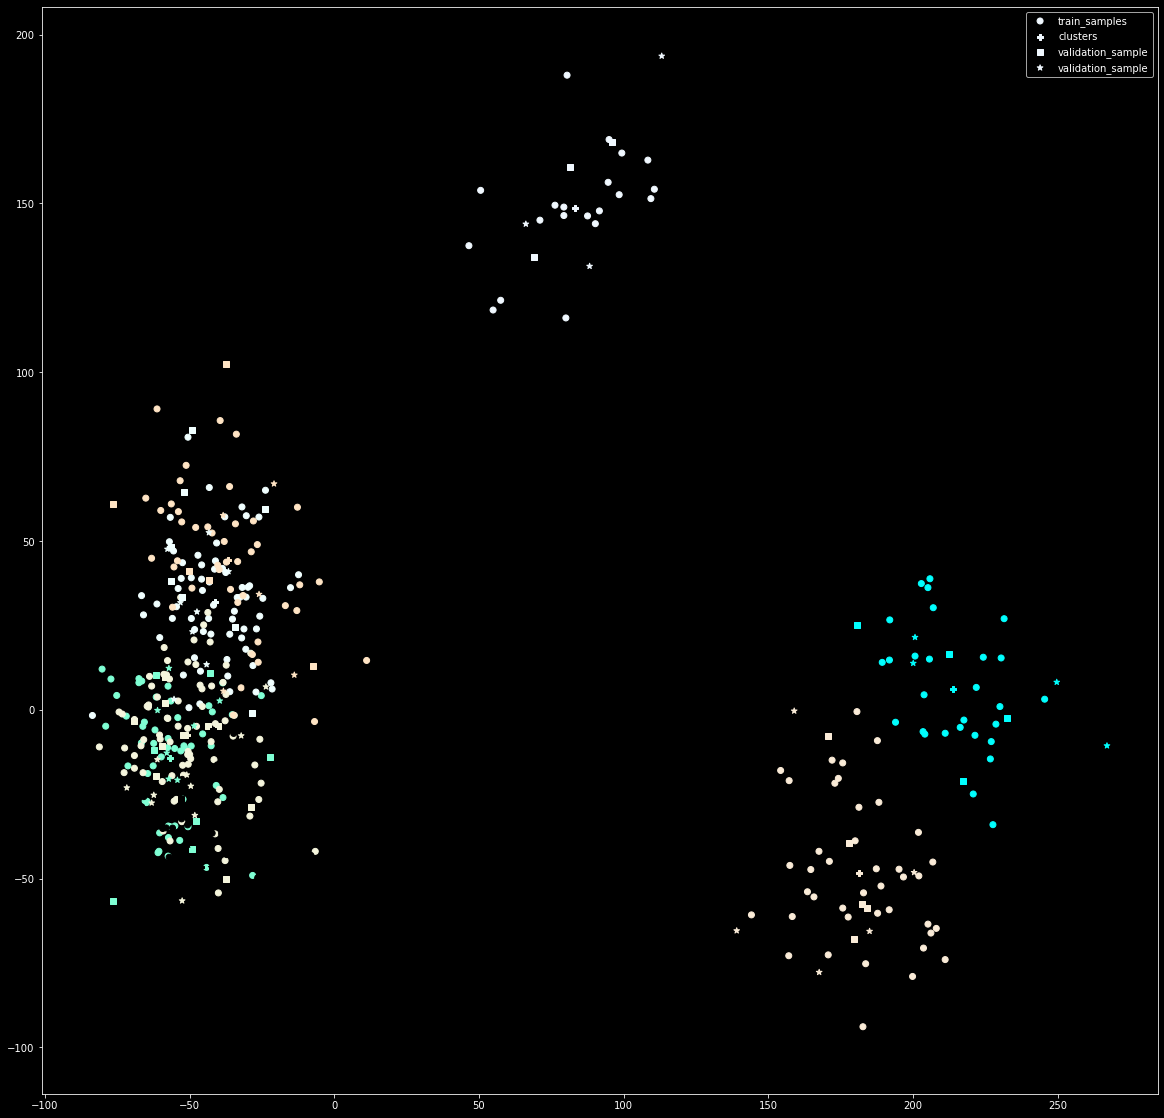

In [ ]:
plot_pca(model_data, labels=np.arange(8),cluster_method='label', show_val=True, show_test=True)

In [ ]:
perplexity = 50

In [ ]:
tsne_2d = TSNE(n_components=2, perplexity=perplexity)

In [ ]:
tsne_test = tsne_2d.fit_transform(features_test)

/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
tsne_2d.fit(features_test)

/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE(perplexity=50)

In [ ]:
tsne_set = tsne_2d.fit_transform(testset)

/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thorreign/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


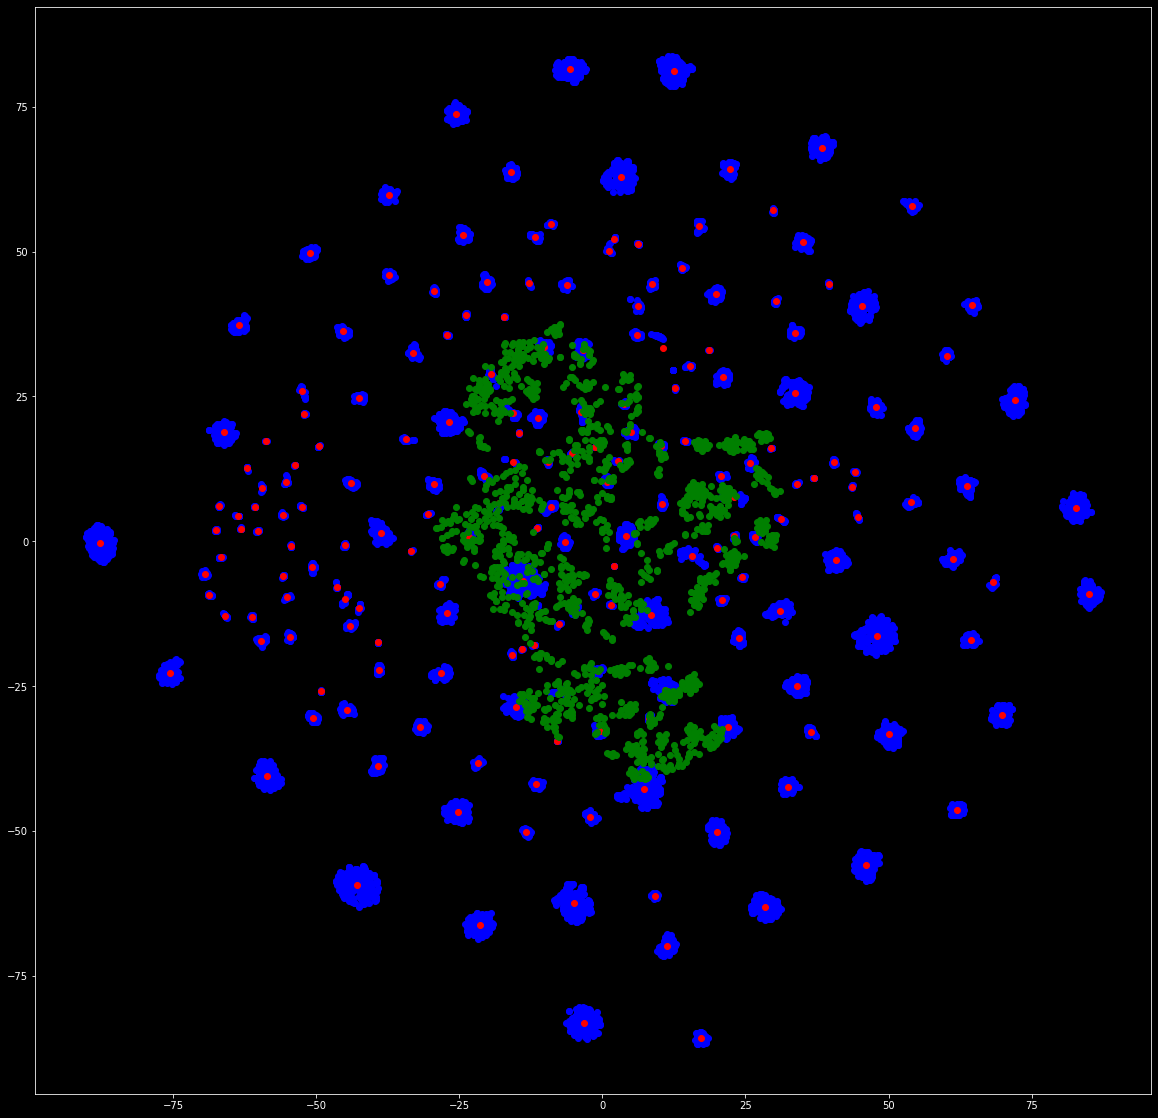

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(tsne_test[:,0],tsne_test[:,1], c='b')
ax.scatter(tsne_test_c_l[:,0],tsne_test_c_l[:,1], c='r')
ax.scatter(tsne_set[:,0],tsne_set[:,1], c='g')

In [ ]:
block

NameError: name 'block' is not defined

In [ ]:
m = torchvision.models.resnet18(False)

In [ ]:
if hasattr(model, 'model'):
    print('yes')


yes


In [ ]:
list(m.children())[7]._get_name()

'Sequential'

In [ ]:
issubclass(torch.nn.modules.batchnorm.BatchNorm2d, torch.nn.modules.batchnorm)

TypeError: issubclass() arg 2 must be a class or tuple of classes

In [ ]:
list(list(m.children())[1].modules())

[BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [ ]:
isinstance(list(m.children())[1], torch.nn.modules.batchnorm._NormBase)

True

In [ ]:
type(list(m.children())[8])

torch.nn.modules.pooling.AdaptiveAvgPool2d

In [ ]:
if list(m.children())[0]._get_name() in torch.nn.modules.conv.__dict__:
    print(1)

1


In [ ]:
isinstance(type(list(m.children())[0]), torch.nn.modules.conv)

TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
type(list(m.children())[4])

torch.nn.modules.container.Sequential

In [ ]:
list(list(m.children())[4].named_children())

[('0',
  BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )),
 ('1',
  BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ))]

In [ ]:
type(torch.nn.modules.batchnorm._NormBase)

type

In [ ]:
class Network_layer:
    def __init__(self, layer, name, tag):
        self.name = name
        self.type = layer._get_name()
        self.tag = tag
        self.next_tag = tag

    def get_tags(self):
        return [self.tag]

    def set_next_tag(self, i, tags):
        self.next_tag = tags[i]
        return i + 1


    def draw_node(self, gra):
        gra.node(self.tag, label=self.name)
        gra.edge(self.tag, self.next_tag)

    def __repr__(self):
        return '(' + self.name + ',' + self.type +  ')'

    def print(self, indent):
        return '\t'*indent + '((' + self.tag + '->'+ self.next_tag + '),' + self.name + ',' + self.type +  ')'

class Conv_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        self.input = layer.in_channels
        self.output = layer.out_channels

class Lin_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        self.input = layer.in_features
        self.output = layer.out_features

class Bn_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        self.input = layer.num_features

class Act_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        pass

class Pool_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        pass

class Block_layer(Network_layer):
    def __init__(self, layer, name, tag):
        super().__init__(layer, name, tag)
        self.sub_layers = []
        i = 0
        for l in layer.named_children():
            sub_tag = self.tag + ',' + str(i)
            self.sub_layers.append(layer_class(l[1], l[0], sub_tag))
            i += 1
    def get_tags(self):
        ret = [self.tag]
        for l in self.sub_layers:
            ret += l.get_tags()
        return ret

    def set_next_tag(self, i, tags):
        self.next_tag = tags[i]
        i += 1
        for l in self.sub_layers:
            i = l.set_next_tag(i, tags)
        
        return i

    def draw_node(self, gra):
        gra.node(self.tag, label=self.name)
        gra.edge(self.tag, self.next_tag)
        for l in self.sub_layers:
            l.draw_node(gra)
        
    def __repr__(self):
        s =  '(' + self.name + ',' + self.type +  ')\n\t[\n'
        for l in self.sub_layers:
            s += '\t' + str(l) + '\n'
        
        return s + '\t]'

    def print(self, indent):
        s =  '\t'*indent + '(('+ self.tag + '->'+ self.next_tag + '),' + self.name + ',' + self.type +  ')\n' + '\t'*indent + '[\n'

        for l in self.sub_layers:
            s += l.print(indent+1) + '\n'

        return s + '\t'*indent + ']'


In [ ]:
def layer_class(layer, name, tag):
    l_type = layer._get_name()

    if l_type in torch.nn.modules.conv.__dict__:
        return Conv_layer(layer, name, tag)

    if l_type in torch.nn.modules.linear.__dict__:
        return Lin_layer(layer, name, tag)

    if l_type in torch.nn.modules.batchnorm.__dict__:
        return Bn_layer(layer, name, tag)

    if l_type in torch.nn.modules.activation.__dict__:
        return Act_layer(layer, name, tag)

    if l_type in torch.nn.modules.pooling.__dict__:
        return Pool_layer(layer, name, tag)

    return Block_layer(layer, name, tag)



In [ ]:
from graphviz import Digraph

In [ ]:
class Network_graph:
    def __init__(self, model):
        if not hasattr(model, 'model'):
            source_model = model
        else:
            source_model = model.model
        self.model = []
        i = 0
        for layer in list(source_model.named_children()):
            self.model.append(layer_class(layer[1], layer[0],str(i)))
            i += 1
        self.tags = []
        for l in self.model:
            self.tags += l.get_tags()

        i = 1
        next_tags = self.tags + ['out']
        for l in self.model:
            i = l.set_next_tag(i,next_tags)

        self.graph_name = 'test'
        
    def __repr__(self):
        s ='[\n'
        for l in self.model:
            s += l.print(1) + '\n'

        return s + ']'

    def render_complete_graph(self, size=None, format='png', engine='dot'):
        if size is not None:
            gra = Digraph(self.graph_name, engine=engine, graph_attr={'size':str(size)})
        else:
            gra = Digraph(self.graph_name, engine=engine)

        for l in self.model:
            l.draw_node(gra)
        gra.render(filename = 'test', format=format)

In [ ]:
test2 = Network_graph(m)

In [ ]:
test2.render_complete_graph()